In [1]:
import torch
import torch.nn as nn

import clip
import numpy as np


### 1. CLIP

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
model, preprocess = clip.load("ViT-B/32")
input_resolution = model.visual.input_resolution

print("Input resolution:", input_resolution)

In [ ]:
trans = model.transformer
trans

### 2. Data

#### 2.0.0 CSI $\rightarrow$ CSI-Ratio

In [2]:
import numpy as np
import math
from scipy.io import loadmat


# 假设CSI数据的形状为 (num_packets, num_antennas, num_subcarriers)
# num_packets: 数据包数量（时间序列）
# num_antennas: 天线数量（3根天线）
# num_subcarriers: 子载波数量（30个子载波）

def calculate_amplitude_variance_ratio(csi_data):
    """
    计算每个天线的所有子载波的幅度方差比之和
    :param csi_data: CSI数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :return: 每个天线的幅度方差比之和，形状为 (num_antennas,)
    """
    # 计算幅度
    amplitude = np.abs(csi_data)  # 形状为 (num_packets, num_antennas, num_subcarriers)

    # 计算每个天线和子载波的幅度方差
    variance = np.var(amplitude, axis=0)  # 形状为 (num_antennas, num_subcarriers)

    # 计算每个天线的幅度方差比之和
    variance_ratio_sum = np.sum(variance, axis=1)  # 形状为 (num_antennas,)

    return variance_ratio_sum

def select_reference_antenna(csi_data):
    """
    选择参考天线（幅度方差比之和最小的天线）
    :param csi_data: CSI数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :return: 参考天线的索引
    """
    variance_ratio_sum = calculate_amplitude_variance_ratio(csi_data)
    reference_antenna_index = np.argmin(variance_ratio_sum)
    return reference_antenna_index

def calculate_csi_ratio(csi_data):
    """
    计算CSI比值（CSI-Ratio）
    :param csi_data: CSI数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :return: CSI比值数据，形状为 (num_packets, num_antennas, num_subcarriers)
    """
    num_packets, num_antennas, num_subcarriers = csi_data.shape

    # 选择参考天线
    reference_antenna_index = select_reference_antenna(csi_data)
    reference_csi = csi_data[:, reference_antenna_index, :]  # 参考天线的CSI数据

    # 计算CSI比值
    csi_ratio = np.zeros_like(csi_data)
    for antenna in range(num_antennas):
        if antenna == reference_antenna_index:
            # 参考天线的CSI比值为1
            csi_ratio[:, antenna, :] = 1.0
        else:
            # 其他天线的CSI比值
            csi_ratio[:, antenna, :] = csi_data[:, antenna, :] / reference_csi

    return csi_ratio, reference_antenna_index

In [ ]:
csi_data = loadmat("../CSI-Data-Fu/user1-1-1-1-1-r2.mat")
csi_data = csi_data['csi_data']
csi_data = csi_data.reshape(csi_data.shape[0], 3, -1)

In [12]:
# 计算CSI比值
csi_ratio, reference_antenna = calculate_csi_ratio(csi_data)
# 输出结果
print("CSI比值数据的形状:", csi_ratio.shape)
print("参考天线的索引:", reference_antenna)

CSI比值数据的形状: (1990, 3, 30)
参考天线的索引: 1


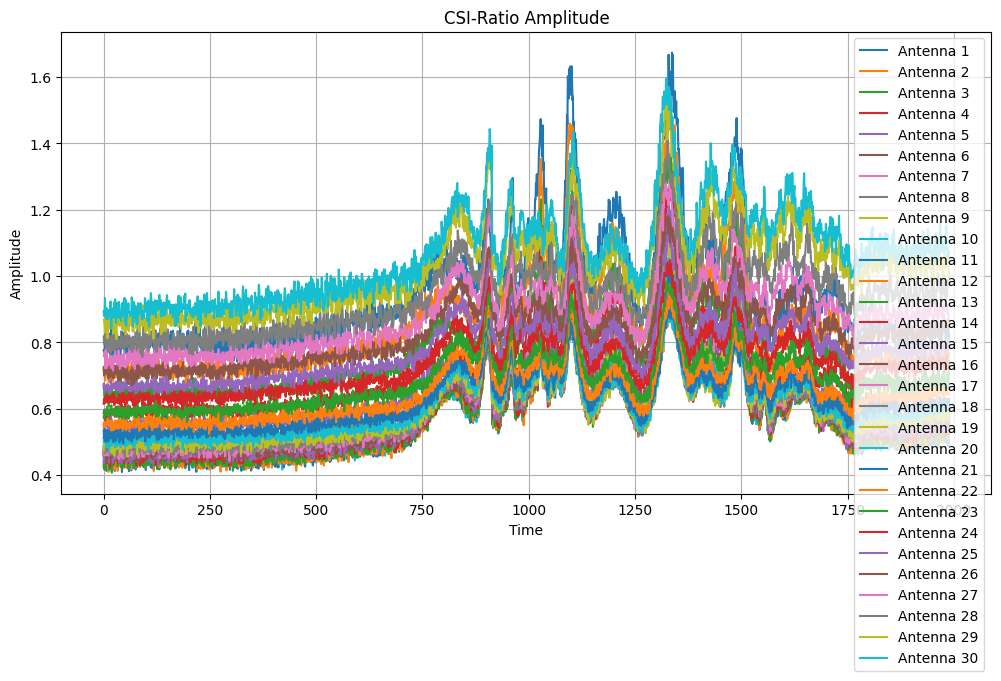

In [14]:
import matplotlib.pyplot as plt

abs_csi_ratio = np.abs(csi_ratio)
plt.figure(figsize=(12, 6))
for i in range(0, 30):
    plt.plot(abs_csi_ratio[:, 0, i], label=f'Antenna {i+1}')

plt.title('CSI-Ratio Amplitude')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

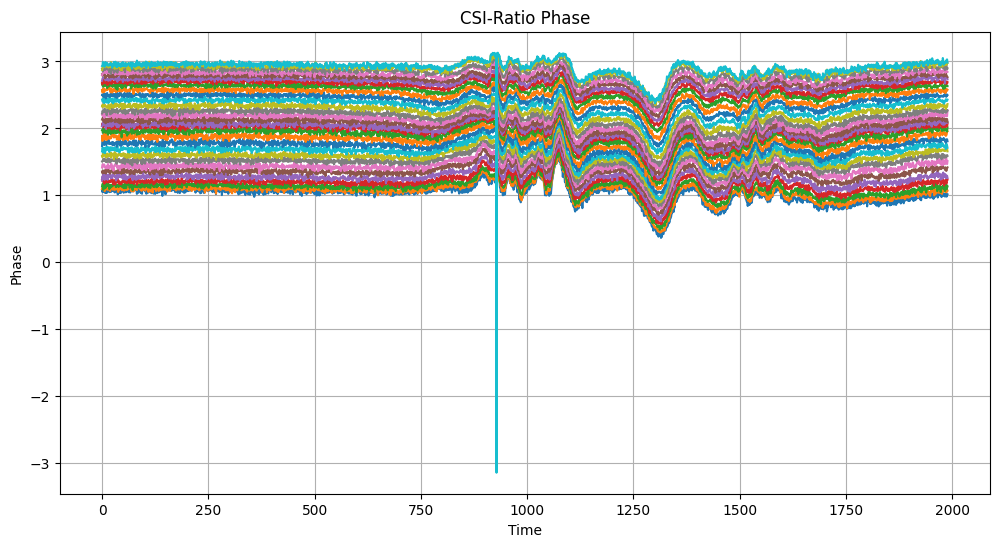

In [15]:
angle_csi_ratio = np.angle(csi_ratio)
plt.figure(figsize=(12, 6))
for i in range(0, 30):
    plt.plot(angle_csi_ratio[:, 0, i], label=f'Antenna {i+1}')

plt.title('CSI-Ratio Phase')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.grid(True)
plt.show()

#### 2.0.1 Denoie CSI-Ratio Phase

In [8]:
def hampel_filter(data, window_size=5, n_sigmas=3):
    """
    使用Hampel滤波器去除时间序列中的异常值。
    
    :param data: 输入的时间序列数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :param window_size: 计算中位数和MAD的窗口大小
    :param n_sigmas: 阈值的倍数
    :return: 去除异常值后的时间序列数据
    """
    filtered_data = np.copy(data)
    num_packets, num_antennas, num_subcarriers = data.shape
    
    for ant in range(num_antennas):
        for sc in range(num_subcarriers):
            sequence = data[:, ant, sc]
            median = np.median(sequence)
            deviation = np.abs(sequence - median)
            mad = np.median(deviation)
            
            # 计算阈值
            threshold = n_sigmas * mad
            
            # 检测异常值
            outliers = deviation > threshold
            
            # 替换异常值为中位数
            filtered_data[outliers, ant, sc] = median
    
    return filtered_data

In [9]:
def phase_calibration(phase_data, epsilon=0.3):
    """
    对CSI-Ratio的相位数据进行相位校准。
    
    参数:
    phase_data: numpy数组，形状为(num_packets, num_antennas, num_subcarriers)，包含相位数据。
    epsilon: 浮点数，经验性设置的阈值，默认为0.3。
    
    返回:
    校准后的相位数据，形状与phase_data相同。
    """
    calibrated_phase_data = phase_data.copy()
    num_packets, num_antennas, num_subcarriers = phase_data.shape
    
    for ant in range(num_antennas):
        for sc in range(num_subcarriers):
            for t in range(1, num_packets):
                phase_diff = calibrated_phase_data[t, ant, sc] - calibrated_phase_data[t-1, ant, sc]
                while abs(phase_diff) > 2 * np.pi - epsilon:
                    if phase_diff > 0:
                        calibrated_phase_data[t, ant, sc] -= 2 * np.pi
                    else:
                        calibrated_phase_data[t, ant, sc] += 2 * np.pi
                    phase_diff = calibrated_phase_data[t, ant, sc] - calibrated_phase_data[t-1, ant, sc]
    
    return calibrated_phase_data

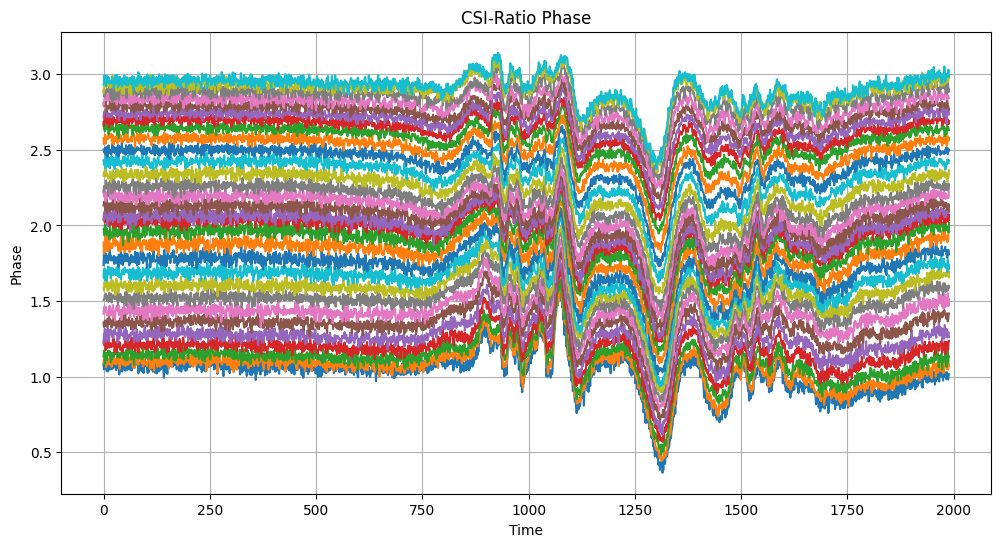

In [20]:
# 进行相位校准
angle_csi_ratio = phase_calibration(angle_csi_ratio)

plt.figure(figsize=(12, 6))
for i in range(0, 30):
    plt.plot(angle_csi_ratio[:, 0, i], label=f'Antenna {i+1}')

plt.title('CSI-Ratio Phase')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.grid(True)
plt.show()

#### 2.0.2 CSI Resample

In [ ]:
import numpy as np
from scipy.interpolate import interp1d, CubicSpline, splev, splrep

def resample_csi_sequence(csi_sequence, target_length=500):
    """
    对单个CSI序列进行重采样至目标长度
    :param csi_sequence: 原始CSI序列，形状为 (original_length, num_antennas, num_subcarriers)
    :param target_length: 目标序列长度（默认为500）
    :return: 重采样后的CSI序列，形状为 (target_length, num_antennas, num_subcarriers)
    """
    original_length = csi_sequence.shape[0]
    num_antennas = csi_sequence.shape[1]
    num_subcarriers = csi_sequence.shape[2]
    
    # 创建新时间轴
    original_time = np.linspace(0, 1, original_length)  # 归一化时间轴
    new_time = np.linspace(0, 1, target_length)          # 目标时间轴
    
    # 初始化输出序列
    resampled_sequence = np.zeros((target_length, num_antennas, num_subcarriers))
    
    # 对每个天线和子载波进行插值
    for ant in range(num_antennas):
        for sc in range(num_subcarriers):
            # 提取原始复数值序列
            complex_sequence = csi_sequence[:, ant, sc]
            
            # 创建插值函数
            interp_real = interp1d(original_time, complex_sequence, kind='linear')

            # 生成新序列
            resampled_real = interp_real(new_time)
            
            resampled_sequence[:, ant, sc] = resampled_real
            
    return resampled_sequence

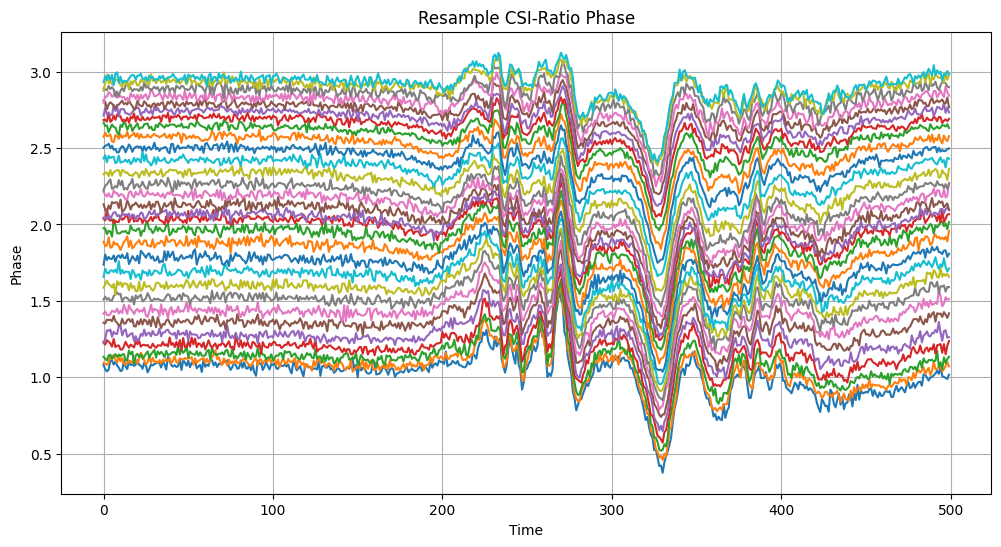

In [23]:
# 执行重采样
resampled_data = resample_csi_sequence(angle_csi_ratio, 500)

# 验证输出形状
plt.figure(figsize=(12, 6))
for i in range(0, 30):
    plt.plot(resampled_data[:, 0, i], label=f'Antenna {i+1}')

plt.title('Resample CSI-Ratio Phase')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.grid(True)
plt.show()

#### 2.0.4 CSI DWT (小波变换)

In [ ]:
# 小波变换去噪
import pywt

def wavelet_denoise(signal, wavelet='db4', level=None, threshold_mode='soft', mode='sym'):
    """
    对一维信号进行小波去噪，支持实数和复数信号。
    """
    if np.iscomplexobj(signal):
        # 复数信号分解为实部和虚部分别处理
        real_part = np.real(signal)
        imag_part = np.imag(signal)
        denoised_real = wavelet_denoise(real_part, wavelet, level, threshold_mode, mode)
        denoised_imag = wavelet_denoise(imag_part, wavelet, level, threshold_mode, mode)
        return denoised_real + 1j * denoised_imag
    else:
        # 实数信号处理
        # 自动计算最大分解层数（如果未指定）
        if level is None:
            level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
            # 如果信号长度不足以进行小波分解，则返回原信号
            if level == 0:
                return signal
        
        try:
            coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
        except ValueError:
            # 分解层数过高，降低层数
            level = pywt.dwt_max_level(len(signal), pywt.Wavelet(wavelet).dec_len)
            if level == 0:
                return signal
            coeffs = pywt.wavedec(signal, wavelet, level=level, mode=mode)
        
        if len(coeffs) < 2:
            return signal
        
        # 使用最高层细节系数估计噪声标准差
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(signal)))
        
        # 阈值处理细节系数
        coeffs_thresholded = [coeffs[0]]  # 保留近似系数
        for i in range(1, len(coeffs)):
            coeffs_thresholded.append(pywt.threshold(coeffs[i], threshold, mode=threshold_mode))
        
        # 重构信号
        denoised_signal = pywt.waverec(coeffs_thresholded, wavelet, mode=mode)
        
        # 确保长度一致
        if len(denoised_signal) != len(signal):
            denoised_signal = np.resize(denoised_signal, len(signal))
        
        return denoised_signal

def denoise_csi_data(csi_data, wavelet='db4', level=None, threshold_mode='soft', mode='sym', n_jobs=None):
    """
    对CSI数据进行小波去噪（支持并行处理）
    
    参数:
        csi_data: 三维CSI数据，形状为(num_packets, num_antennas, num_subcarriers)
        n_jobs: 并行任务数（None表示串行处理）
    """
    num_packets, num_antennas, num_subcarriers = csi_data.shape
    csi_denoised = np.zeros_like(csi_data)
    
    # 并行处理
    if n_jobs is not None and n_jobs != 1:
        from joblib import Parallel, delayed
        results = Parallel(n_jobs=n_jobs)(
            delayed(wavelet_denoise)(csi_data[:, i, j], wavelet, level, threshold_mode, mode)
            for i in range(num_antennas)
            for j in range(num_subcarriers)
        )
        
        idx = 0
        for i in range(num_antennas):
            for j in range(num_subcarriers):
                csi_denoised[:, i, j] = results[idx]
                idx += 1
    else:
        # 串行处理
        for i in range(num_antennas):
            for j in range(num_subcarriers):
                csi_denoised[:, i, j] = wavelet_denoise(
                    csi_data[:, i, j], 
                    wavelet=wavelet,
                    level=level,
                    threshold_mode=threshold_mode,
                    mode=mode
                )
    
    return csi_denoised

In [ ]:
# 生成示例CSI数据（复数）
num_packets = 1000
num_antennas = 2
num_subcarriers = 30
csi_data = np.random.randn(num_packets, num_antennas, num_subcarriers) + \
            1j * np.random.randn(num_packets, num_antennas, num_subcarriers)

# 去噪处理（使用4个并行进程）
csi_denoised = denoise_csi_data(csi_data, n_jobs=4)

print("原始数据形状:", csi_data.shape)
print("去噪后数据形状:", csi_denoised.shape)

#### 2.0.5 CSI PCA+STFT

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import stft

def apply_pca(amplitude_data, n_components=10):
    """
    对幅度数据进行PCA降维。
    
    :param amplitude_data: 幅度数据，形状为 (num_packets, num_antennas, num_subcarriers)
    :param n_components: 降维后的主成分数量
    :return: 降维后的数据，形状为 (num_packets, num_antennas, n_components)
    """
    num_packets, num_antennas, num_subcarriers = amplitude_data.shape
    pca = PCA(n_components=n_components)
    
    # 对每个天线和子载波进行PCA降维
    pca_data = np.zeros((num_packets, num_antennas, n_components))
    for ant in range(num_antennas):
        pca_data[:, ant, :] = pca.fit_transform(amplitude_data[:, ant, :])
    
    return pca_data

def apply_stft(pca_data, fs=1.0, window='hann', nperseg=256, noverlap=None):
    """
    对降维后的数据进行短时傅里叶变换。
    :param pca_data: 降维后的数据，形状为 (num_packets, num_antennas, n_components)
    :param fs: 采样频率
    :param window: 窗口函数
    :param nperseg: 每个分段的长度
    :param noverlap: 分段之间的重叠长度
    :return: STFT结果，形状为 (num_antennas, n_components, n_freqs, n_segments)
    """
    num_packets, num_antennas, n_components = pca_data.shape
    stft_results = []
    
    for ant in range(num_antennas):
        for comp in range(n_components):
            f, t, Zxx = stft(pca_data[:, ant, comp], fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
            stft_results.append(Zxx)
    
    stft_results = np.array(stft_results).reshape(num_antennas, n_components, *Zxx.shape)
    return f, t, stft_results


In [25]:
csi_data = loadmat("../CSI-Data-Fu/user1-1-1-1-1-r2.mat")
csi_data = csi_data['csi_data']
csi_data = csi_data.reshape(csi_data.shape[0], 3, -1)

# 计算幅度
amplitude_data = np.abs(csi_data)

# PCA降维
pca_data = apply_pca(amplitude_data, n_components=10)

# 短时傅里叶变换
fs = 1.0  # 假设采样频率为1 Hz
window = 'hann'
nperseg = 256
noverlap = 128

f, t, stft_results = apply_stft(pca_data, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)

# 输出结果
print("STFT结果形状:", stft_results.shape)

STFT结果形状: (3, 10, 129, 17)


#### 2.0.6 Extract DFS from CSI

In [ ]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# 加载CSI数据
csi_data = loadmat("../CSI-Data-Fu/user1-1-1-1-1-r2.mat")['csi_data']
csi_data = csi_data.reshape(csi_data.shape[0], 3, -1)

# 提取幅度和相位
amplitude = np.abs(csi_data)
phase = np.angle(csi_data)

# 计算相邻数据包之间的相位变化
phase_diff = np.diff(phase, axis=0)

# 应用傅里叶变换到相位变化上
dfs = np.fft.fft(phase_diff, axis=0)

# 计算频率轴
num_packets = csi_data.shape[0]
sampling_rate = 100e6  # 假设采样率为100MHz
subcarrier_spacing = 312.5e3  # 假设子载波间隔为312.5kHz
num_subcarriers = csi_data.shape[2]
max_doppler_shift = sampling_rate / 2  # 最大多普勒频移
doppler_bins = np.fft.fftfreq(num_packets-1, d=1/sampling_rate)

# 只考虑正频率部分
positive_doppler_bins = doppler_bins[:num_packets//2]
positive_dfs = dfs[:num_packets//2]

# 绘制多普勒频移谱图
plt.figure(figsize=(12, 8))
for antenna in range(num_antennas):
    for subcarrier in range(num_subcarriers):
        plt.plot(positive_doppler_bins, np.abs(positive_dfs[:, antenna, subcarrier]), label=f'Antenna {antenna+1}, Subcarrier {subcarrier+1}')
plt.title('Doppler Frequency Shift Spectrum')
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()

#### 2.1 CSI Dataset 

In [ ]:
import scipy.io as sio
import os
import numpy as np
from typing import List
import random
import pywt

from dataset.data import get_csi_data
from dataset.datasets import CSI_Dataset, HAR_Dataset
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [ ]:
# Widar
data_path = '../data'
batch_size = 20
time_length = 2000
req_domains = ['users', 'gesture_type', 'tosor_loc', 'face_ori', 'rec_dev']

In [ ]:
train_datas, train_labels, eval_datas, eval_labels = get_csi_data(
    data_path, 
    req_domains=req_domains,
)

train_labels.shape

In [ ]:
# HAR
train_datas = HAR_Dataset('D:/NTU-Fi_HAR/train_amp', time_length=2000)

#### 2.2 DFS Data

In [ ]:
import scipy.io as sio
import os
import numpy as np
from typing import List
import random
import pywt

from dataset.data import get_dfs_data
from dataset.datasets import DFS_Dataset
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [ ]:
dfs_data_path = '../dfs_data'
req_domains = ['users', 'gesture_type', 'tosor_loc', 'face_ori']

In [ ]:
train_datas, train_labels, eval_datas, eval_labels = get_dfs_data(dfs_data_path, req_domains)

In [ ]:
train_dataset = DFS_Dataset(
    dfs_data_path,
    train_datas,
    train_labels
)

### 3.Model

In [ ]:
from model.embed import TokenEmbedding

from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


### GPT2

In [1]:
import torch
from transformers.models.gpt2.modeling_gpt2 import GPT2Model, GPT2Config

d:\Anaconda\envs\Deep_Learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_config = GPT2Config.from_pretrained('openai-community/gpt2')
model_config

In [3]:
# GPT2 Model
model = GPT2Model.from_pretrained('openai-community/gpt2')
model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [4]:
word_weight = model.get_input_embeddings().weight
word_weight.requires_grad

True

### Qwen2.5-3B

In [ ]:
import torch
from transformers import Qwen2ForCausalLM, Qwen2Model, Qwen2Config

from peft import get_peft_model, LoraConfig, TaskType

In [ ]:
model_config = Qwen2Config.from_pretrained('unsloth/Qwen2.5-3B')
model_config.num_hidden_layers = 12
model_config

In [ ]:
model = Qwen2Model.from_pretrained('unsloth/Qwen2.5-3B', config=model_config)
model

#### Llama-3-8B

In [5]:
import torch
from transformers import LlamaModel, LlamaConfig

In [6]:
model_config = LlamaConfig.from_pretrained('unsloth/Llama-3.2-1B')
model_config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.46.2",
  "unsloth_fixed": true,
  "use_cache": true,
  "vocab_size": 128256
}

In [ ]:
model = LlamaModel.from_pretrained('unsloth/Llama-3.2-1B')
model